# Imports

In [1]:
import os
import json
import pickle
import tarfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from utils import *

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Define Helper Functions

In [3]:
# define a function to save the feature vector dictionary to disk
def load_feature_data(vectors_filepath, names_filepath):
    
    # extract the JSON file from the tar.gz file
    with tarfile.open(vectors_filepath, 'r:gz') as tar:
        tar.extractall()
        json_filename = tar.getnames()[0]  # assuming only one file in the archive
    
    # load the JSON file and convert Python lists back to numpy arrays
    with open(json_filename, 'r') as f:
        feature_vectors_dict = json.load(f)
    
    feature_vectors = {}
    for class_name, vectors in feature_vectors_dict.items():
        feature_vectors[class_name] = [np.array(vector) for vector in vectors]
    
    # remove the extracted JSON file
    os.remove(json_filename)
    
    # load feature names
    with open(names_filepath, 'rb') as f:
        feature_names = pickle.load(f)
        
    return feature_vectors, feature_names

In [4]:
# define a function to visualize the PCA elbow plot
def evaluate_pca(pca):
    
    # compute the cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # plot the elbow plot
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative % of Variation Explained')
    plt.title('Principal Component Elbow Plot')
    plt.grid(True)
    
    # find the location of inflection point
    # NOTE: this is used to determine the best number of PC's
    diff = np.diff(cumulative_variance)
    inflection_point = np.argmax(diff < np.mean(diff))
    plt.axvline(x=inflection_point + 1, color='r', linestyle='--')
    plt.axhline(y=cumulative_variance[inflection_point], color='r', linestyle='--')
    
    # add label to indicate inflection point
    plt.text(inflection_point + 50, cumulative_variance[inflection_point] - .2,
            f"n_components={inflection_point + 1}\ncum_%_variation={cumulative_variance[inflection_point]*100:.2f}%", color='r', fontsize=10)

    plt.show()
    
    return inflection_point + 1
    

In [5]:
# define a function to display the main features that contribute to a set of top PC's
def display_loadings(pca, n_pc=5, n_features=10):
    
    # extract top principal components
    top_components = pca.components_[:n_pc]

    # create dataframes for top principal components
    for i, component in enumerate(top_components):
        loading_scores = pd.DataFrame({'feature_name': feature_names, 'loading_score': component})
        loading_scores = loading_scores.sort_values(by='loading_score', ascending=False).head(n_features)
        print(f"Top {n_features} features for Principal Component {i + 1}:")
        display(loading_scores)

# Load data

In [6]:
# define file directory
directory = '../data/interim/PatternNet/PatternNet/images'

# create a list of classes considered for this project
classes = ['beach', 'chaparral', 'dense_residential', 'forest', 'freeway', 'harbor', 'overpass', 'parking_space', 'river', 'swimming_pool']

In [7]:
# load feature data from disk
feature_vectors, feature_names = load_feature_data("../data/processed/feature_vectors_2.tar.gz", "../data/processed/feature_names_2.pkl")

In [8]:
# inspections
print(type(feature_vectors))
print(feature_vectors.keys())
print(type(feature_vectors['beach']))
print(len(feature_vectors['beach']))
print(type(feature_vectors['beach'][0]))
print(len(feature_vectors['beach'][0]))
print(feature_vectors['beach'][0])

<class 'dict'>
dict_keys(['parking_space', 'beach', 'forest', 'overpass', 'river', 'dense_residential', 'swimming_pool', 'chaparral', 'freeway', 'harbor'])
<class 'list'>
479
<class 'numpy.ndarray'>
1367
[1.13955765e+02 1.27463531e+02 1.19847519e+02 ... 2.08073282e-01
 3.18124076e-02 8.04467964e-01]


# Transform data

In [9]:
# flatten feature vectors and prepare data for PCA
X = []
for class_name in classes:
    X.extend(feature_vectors[class_name])
X = np.array(X)
print(X.shape)

# standardize data
features_scaler = StandardScaler()
X = features_scaler.fit_transform(X)

# save the standardization scaler to disk
with open("../data/processed/features_scaler.pkl", 'wb') as f:
    pickle.dump(features_scaler, f)

(4799, 1367)


# Principal Component Analysis

In [10]:
# perform PCA
pca_model = PCA()
pca_model.fit(X)

PCA()

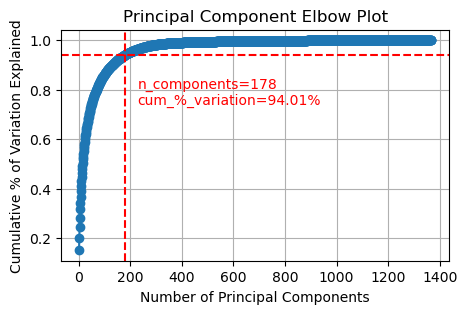

In [11]:
n_pc_components = evaluate_pca(pca_model)

In [12]:
display_loadings(pca_model, n_pc=5, n_features=5)

Top 5 features for Principal Component 1:


,feature_name,loading_score
1272,hog_1206,0.039310
1056,hog_990,0.039002
1236,hog_1170,0.038068
1260,hog_1194,0.037947
1240,hog_1174,0.037861


Top 5 features for Principal Component 2:


,feature_name,loading_score
662,hog_596,0.067197
878,hog_812,0.062848
866,hog_800,0.062127
674,hog_608,0.061544
650,hog_584,0.060696


Top 5 features for Principal Component 3:


,feature_name,loading_score
186,hog_120,0.053842
390,hog_324,0.051271
402,hog_336,0.048337
666,hog_600,0.047787
634,hog_568,0.047070


Top 5 features for Principal Component 4:


,feature_name,loading_score
1364,homogeneity_mean,0.062917
821,hog_755,0.061451
857,hog_791,0.059044
856,hog_790,0.058975
818,hog_752,0.057720


Top 5 features for Principal Component 5:


,feature_name,loading_score
393,hog_327,0.067954
785,hog_719,0.067741
784,hog_718,0.067106
884,hog_818,0.067086
885,hog_819,0.065159


In [13]:
# re-compute pca model with optimum number of PC's
pca_model = PCA(n_components=n_pc_components)
pca_model.fit(X)

# save the pca model to disk
with open("../data/processed/pca_model.pkl", 'wb') as f:
    pickle.dump(pca_model, f)